# GroundThink Task 0.3: Twin Debate Loss

**Version:** 0.5.1.4  
**Date:** 2026-01-15  
**Status:** Phase 1 - Loss Function Implementation

---

## Background

Previous tasks established:
- ✅ Task 0.1: minGRU Arbiter with RMSNorm (gold standard)
- ✅ Task 0.2: Mamba Residual Path (prevents collapse)
- ✅ Task 0.3b: 8-Layer stability proven

**This Task:** Implement loss functions that encourage pathway specialization.

### The Problem

Even with stable arbitration, both agencies might learn similar features. We want RWKV and Mamba to specialize in different aspects of the input.

### Solution: Twin Debate Loss

```
L_total = L_task + λ_div * L_diversity + λ_arb * L_arbiter
```

1. **L_task**: Standard language modeling loss (CE)
2. **L_diversity**: Penalize similar agency outputs (cosine similarity)
3. **L_arbiter**: Reward arbiter for selecting the better pathway

---

## This Notebook

1. Implement each loss component
2. Validate behavior with toy examples
3. Integration with GroundThink model
4. Export to `tools/debate_loss.py`

## 1. Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

print(f"PyTorch: {torch.__version__}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch: 2.9.0+cpu
Using device: cpu


## 2. L_diversity: Pathway Divergence Loss

Penalizes RWKV and Mamba for producing similar outputs.

**Goal:** Force specialization - each agency should capture different features.

In [2]:
class DiversityLoss(nn.Module):
    """Penalize similar outputs between agencies.
    
    Uses negative cosine similarity: high similarity = high loss.
    
    Args:
        reduction: 'mean' or 'none'
    """
    
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction
    
    def forward(self, rwkv_out, mamba_out):
        """Compute diversity loss.
        
        Args:
            rwkv_out: (B, L, D) RWKV agency output
            mamba_out: (B, L, D) Mamba agency output
        
        Returns:
            loss: Scalar if reduction='mean', else (B, L)
        """
        # Normalize along feature dimension
        rwkv_norm = F.normalize(rwkv_out, dim=-1)
        mamba_norm = F.normalize(mamba_out, dim=-1)
        
        # Cosine similarity per position
        cos_sim = (rwkv_norm * mamba_norm).sum(dim=-1)  # (B, L)
        
        # Loss: we want LOW similarity, so penalize high values
        # cos_sim in [-1, 1], we want to push toward -1 (orthogonal/opposite)
        # Simple approach: loss = (1 + cos_sim) / 2, maps [-1,1] to [0,1]
        loss = (1 + cos_sim) / 2
        
        if self.reduction == 'mean':
            return loss.mean()
        return loss


# Test
div_loss = DiversityLoss()

# Similar outputs -> high loss
x = torch.randn(2, 32, 128)
loss_similar = div_loss(x, x + 0.1 * torch.randn_like(x))

# Different outputs -> low loss
y = torch.randn(2, 32, 128)
loss_different = div_loss(x, y)

# Orthogonal outputs -> lowest loss
z = torch.randn(2, 32, 128)
z = z - (z * x).sum(-1, keepdim=True) * x / (x.norm(dim=-1, keepdim=True)**2 + 1e-8)
loss_orthogonal = div_loss(x, z)

print("DiversityLoss Test:")
print(f"  Similar outputs:    {loss_similar.item():.4f} (should be HIGH)")
print(f"  Random outputs:     {loss_different.item():.4f} (should be MEDIUM)")
print(f"  Orthogonal outputs: {loss_orthogonal.item():.4f} (should be LOW)")
print(f"\n✓ DiversityLoss working correctly" if loss_similar > loss_different > loss_orthogonal else "✗ Check implementation")

DiversityLoss Test:
  Similar outputs:    0.9976 (should be HIGH)
  Random outputs:     0.5077 (should be MEDIUM)
  Orthogonal outputs: 0.5000 (should be LOW)

✓ DiversityLoss working correctly


## 3. L_arbiter: Trust Calibration Loss

Rewards the arbiter for weighting the pathway that performs better.

**Goal:** Arbiter should learn to trust the agency with lower reconstruction error.

In [3]:
class ArbiterLoss(nn.Module):
    """Reward arbiter for selecting better-performing pathway.
    
    Computes per-pathway loss, then penalizes arbiter weights
    that favor the higher-loss pathway.
    
    Args:
        reduction: 'mean' or 'none'
    """
    
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction
    
    def forward(self, rwkv_out, mamba_out, weights, target):
        """Compute arbiter calibration loss.
        
        Args:
            rwkv_out: (B, L, D) RWKV agency output
            mamba_out: (B, L, D) Mamba agency output
            weights: (B, L, 2) arbiter weights [α_rwkv, α_mamba]
            target: (B, L, D) target for reconstruction
        
        Returns:
            loss: Scalar if reduction='mean'
        """
        # Per-pathway reconstruction error
        rwkv_error = (rwkv_out - target).pow(2).mean(dim=-1)  # (B, L)
        mamba_error = (mamba_out - target).pow(2).mean(dim=-1)  # (B, L)
        
        # Which pathway is better? (lower error = better)
        # target_weights: should be [1, 0] if RWKV better, [0, 1] if Mamba better
        rwkv_better = (rwkv_error < mamba_error).float()  # (B, L)
        mamba_better = 1 - rwkv_better
        
        target_weights = torch.stack([rwkv_better, mamba_better], dim=-1)  # (B, L, 2)
        
        # Cross-entropy between actual weights and target weights
        # Soft target, so use KL divergence / cross-entropy
        log_weights = torch.log(weights + 1e-8)
        loss = -(target_weights * log_weights).sum(dim=-1)  # (B, L)
        
        if self.reduction == 'mean':
            return loss.mean()
        return loss


# Test
arb_loss = ArbiterLoss()

B, L, D = 2, 32, 128
target = torch.randn(B, L, D)

# RWKV closer to target
rwkv_close = target + 0.1 * torch.randn_like(target)
mamba_far = target + 1.0 * torch.randn_like(target)

# Good weights (trust RWKV more)
weights_good = torch.zeros(B, L, 2)
weights_good[..., 0] = 0.9  # RWKV
weights_good[..., 1] = 0.1  # Mamba

# Bad weights (trust Mamba more - wrong!)
weights_bad = torch.zeros(B, L, 2)
weights_bad[..., 0] = 0.1
weights_bad[..., 1] = 0.9

loss_good = arb_loss(rwkv_close, mamba_far, weights_good, target)
loss_bad = arb_loss(rwkv_close, mamba_far, weights_bad, target)

print("ArbiterLoss Test:")
print(f"  Correct weighting (trust RWKV): {loss_good.item():.4f} (should be LOW)")
print(f"  Wrong weighting (trust Mamba):  {loss_bad.item():.4f} (should be HIGH)")
print(f"\n✓ ArbiterLoss working correctly" if loss_good < loss_bad else "✗ Check implementation")

ArbiterLoss Test:
  Correct weighting (trust RWKV): 0.1054 (should be LOW)
  Wrong weighting (trust Mamba):  2.3026 (should be HIGH)

✓ ArbiterLoss working correctly


## 4. TwinDebateLoss: Combined Loss

Wraps all components with configurable weights.

In [4]:
class TwinDebateLoss(nn.Module):
    """Combined loss for Twin Debate architecture.
    
    L_total = L_task + λ_div * L_diversity + λ_arb * L_arbiter
    
    Args:
        lambda_diversity: Weight for diversity loss (default: 0.1)
        lambda_arbiter: Weight for arbiter loss (default: 0.1)
        task_loss_fn: Primary task loss (default: CrossEntropyLoss)
    """
    
    def __init__(
        self,
        lambda_diversity: float = 0.1,
        lambda_arbiter: float = 0.1,
        task_loss_fn: nn.Module = None
    ):
        super().__init__()
        self.lambda_diversity = lambda_diversity
        self.lambda_arbiter = lambda_arbiter
        
        self.diversity_loss = DiversityLoss()
        self.arbiter_loss = ArbiterLoss()
        self.task_loss_fn = task_loss_fn or nn.CrossEntropyLoss()
    
    def forward(
        self,
        logits: torch.Tensor,
        targets: torch.Tensor,
        rwkv_out: torch.Tensor,
        mamba_out: torch.Tensor,
        weights: torch.Tensor,
        fused_out: torch.Tensor = None
    ):
        """Compute combined Twin Debate loss.
        
        Args:
            logits: (B, L, V) model output logits for task loss
            targets: (B, L) target token indices for task loss
            rwkv_out: (B, L, D) RWKV agency hidden output
            mamba_out: (B, L, D) Mamba agency hidden output
            weights: (B, L, 2) arbiter weights
            fused_out: (B, L, D) fused output for arbiter target (optional)
        
        Returns:
            total_loss: Combined scalar loss
            loss_dict: Dictionary with individual loss components
        """
        # Task loss (language modeling)
        B, L, V = logits.shape
        l_task = self.task_loss_fn(
            logits.view(B * L, V),
            targets.view(B * L)
        )
        
        # Diversity loss
        l_diversity = self.diversity_loss(rwkv_out, mamba_out)
        
        # Arbiter loss (use fused output as target if not provided)
        if fused_out is None:
            # Use weighted combination as implicit target
            fused_out = weights[..., 0:1] * rwkv_out + weights[..., 1:2] * mamba_out
        l_arbiter = self.arbiter_loss(rwkv_out, mamba_out, weights, fused_out.detach())
        
        # Combined
        total = l_task + self.lambda_diversity * l_diversity + self.lambda_arbiter * l_arbiter
        
        return total, {
            'task': l_task.item(),
            'diversity': l_diversity.item(),
            'arbiter': l_arbiter.item(),
            'total': total.item()
        }


print("✓ TwinDebateLoss defined")

✓ TwinDebateLoss defined


## 5. Integration Test

Test with the GroundThink model from Task 0.3b.

In [5]:
# Import model components from 0.3b
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def forward(self, x):
        norm = torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
        return x * norm * self.weight

def heinsen_associative_scan_log(log_coeffs, log_values):
    a_star = log_coeffs.cumsum(dim=1)
    log_h0_plus_b_star = (log_values - a_star).logcumsumexp(dim=1)
    return (a_star + log_h0_plus_b_star).exp()

def log_g(x):
    return torch.where(x >= 0, (F.relu(x) + 0.5).log(), -F.softplus(-x))

class minGRUArbiter(nn.Module):
    def __init__(self, d_model, expansion_factor=1.5):
        super().__init__()
        inner = int(d_model * expansion_factor)
        self.norm_rwkv = RMSNorm(d_model)
        self.norm_mamba = RMSNorm(d_model)
        self.to_hidden_and_gate = nn.Linear(2 * d_model, inner * 2, bias=False)
        self.to_weights = nn.Linear(inner, 2, bias=False)
        nn.init.zeros_(self.to_weights.weight)
    
    def forward(self, rwkv_out, mamba_out):
        x = torch.cat([self.norm_rwkv(rwkv_out), self.norm_mamba(mamba_out)], dim=-1)
        h, gate = self.to_hidden_and_gate(x).chunk(2, dim=-1)
        log_coeffs = -F.softplus(gate)
        log_z = -F.softplus(-gate)
        out = heinsen_associative_scan_log(log_coeffs, log_z + log_g(h))
        weights = torch.softmax(self.to_weights(out), dim=-1)
        fused = weights[..., 0:1] * rwkv_out + weights[..., 1:2] * mamba_out
        return fused, weights, rwkv_out, mamba_out  # Return agency outputs for loss

class TwinDebateBlock(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.rwkv_agency = nn.Linear(d_model, d_model)
        self.mamba_agency = nn.Linear(d_model, d_model)
        self.arbiter = minGRUArbiter(d_model)
        self.post_norm = RMSNorm(d_model)
    
    def forward(self, x):
        h_rwkv = self.rwkv_agency(x)
        h_mamba = x + self.mamba_agency(x)
        fused, weights, rwkv_out, mamba_out = self.arbiter(h_rwkv, h_mamba)
        output = x + self.post_norm(fused)
        return output, weights, rwkv_out, mamba_out

class GroundThinkLM(nn.Module):
    """Full model with embedding and LM head for loss testing."""
    def __init__(self, vocab_size=1000, d_model=256, n_layers=4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.layers = nn.ModuleList([TwinDebateBlock(d_model) for _ in range(n_layers)])
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)
    
    def forward(self, input_ids):
        x = self.embedding(input_ids)
        all_weights, all_rwkv, all_mamba = [], [], []
        
        for layer in self.layers:
            x, weights, rwkv_out, mamba_out = layer(x)
            all_weights.append(weights)
            all_rwkv.append(rwkv_out)
            all_mamba.append(mamba_out)
        
        logits = self.lm_head(x)
        
        # Average across layers for loss computation
        avg_weights = torch.stack(all_weights).mean(dim=0)
        avg_rwkv = torch.stack(all_rwkv).mean(dim=0)
        avg_mamba = torch.stack(all_mamba).mean(dim=0)
        
        return logits, avg_weights, avg_rwkv, avg_mamba, x


print("✓ Model components defined")

✓ Model components defined


Integration Test: Training with TwinDebateLoss
Model parameters: 784,384
Step 10: task=7.706, div=0.663, arb=2.633
Step 20: task=7.605, div=0.664, arb=4.490
Step 30: task=7.444, div=0.629, arb=3.990
Step 40: task=7.334, div=0.575, arb=2.957
Step 50: task=7.434, div=0.539, arb=2.695


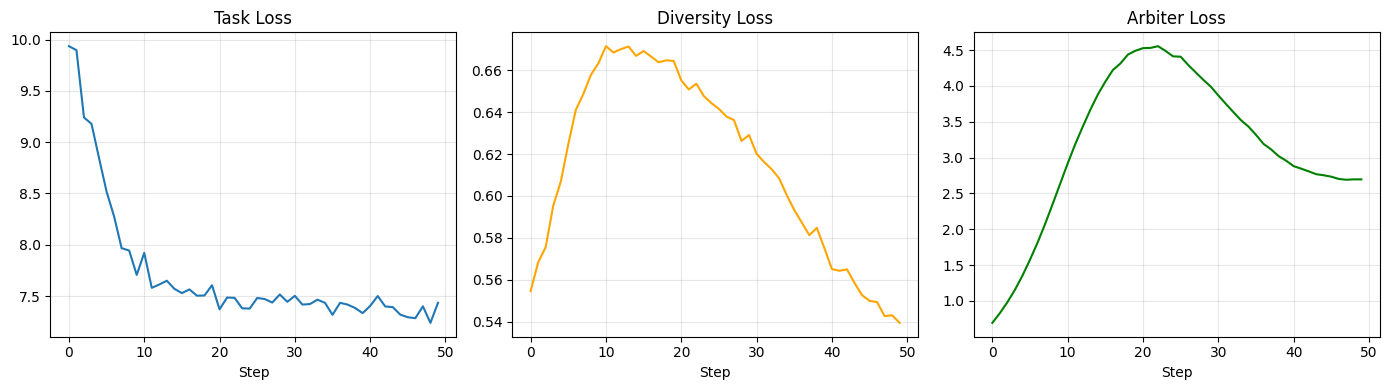


✓ Integration test complete


In [6]:
# Integration test
print("="*60)
print("Integration Test: Training with TwinDebateLoss")
print("="*60)

# Setup
model = GroundThinkLM(vocab_size=1000, d_model=128, n_layers=4).to(device)
loss_fn = TwinDebateLoss(lambda_diversity=0.1, lambda_arbiter=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {n_params:,}")

# Training loop
n_steps = 50
history = {'task': [], 'diversity': [], 'arbiter': [], 'total': []}

model.train()
for step in range(n_steps):
    # Random batch
    input_ids = torch.randint(0, 1000, (4, 64), device=device)
    targets = torch.randint(0, 1000, (4, 64), device=device)
    
    # Forward
    logits, weights, rwkv_out, mamba_out, fused_out = model(input_ids)
    
    # Loss
    total_loss, loss_dict = loss_fn(
        logits, targets,
        rwkv_out, mamba_out,
        weights, fused_out
    )
    
    # Backward
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # Record
    for k, v in loss_dict.items():
        history[k].append(v)
    
    if (step + 1) % 10 == 0:
        print(f"Step {step+1}: task={loss_dict['task']:.3f}, div={loss_dict['diversity']:.3f}, arb={loss_dict['arbiter']:.3f}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].plot(history['task'], label='Task (CE)')
axes[0].set_title('Task Loss')
axes[0].set_xlabel('Step')
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['diversity'], color='orange', label='Diversity')
axes[1].set_title('Diversity Loss')
axes[1].set_xlabel('Step')
axes[1].grid(True, alpha=0.3)

axes[2].plot(history['arbiter'], color='green', label='Arbiter')
axes[2].set_title('Arbiter Loss')
axes[2].set_xlabel('Step')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('debate_loss_training.png', dpi=150)
plt.show()

print("\n✓ Integration test complete")

## 6. Export to tools/debate_loss.py

In [7]:
production_code = '''"""Twin Debate Loss Functions.

Task 0.3 implementation: Loss functions to encourage pathway specialization
in the Twin Debate (RWKV + Mamba) architecture.

Components:
- DiversityLoss: Penalize similar agency outputs
- ArbiterLoss: Reward arbiter for selecting better pathway
- TwinDebateLoss: Combined loss with configurable weights

Usage:
    loss_fn = TwinDebateLoss(lambda_diversity=0.1, lambda_arbiter=0.1)
    total_loss, loss_dict = loss_fn(
        logits, targets,
        rwkv_out, mamba_out,
        weights, fused_out
    )
"""

import torch
import torch.nn as nn
import torch.nn.functional as F


class DiversityLoss(nn.Module):
    """Penalize similar outputs between agencies.
    
    Uses negative cosine similarity: high similarity = high loss.
    Forces RWKV and Mamba to specialize in different features.
    """
    
    def __init__(self, reduction="mean"):
        super().__init__()
        self.reduction = reduction
    
    def forward(self, rwkv_out, mamba_out):
        rwkv_norm = F.normalize(rwkv_out, dim=-1)
        mamba_norm = F.normalize(mamba_out, dim=-1)
        cos_sim = (rwkv_norm * mamba_norm).sum(dim=-1)
        loss = (1 + cos_sim) / 2
        
        if self.reduction == "mean":
            return loss.mean()
        return loss


class ArbiterLoss(nn.Module):
    """Reward arbiter for selecting better-performing pathway.
    
    Computes per-pathway loss, then penalizes arbiter weights
    that favor the higher-loss pathway.
    """
    
    def __init__(self, reduction="mean"):
        super().__init__()
        self.reduction = reduction
    
    def forward(self, rwkv_out, mamba_out, weights, target):
        rwkv_error = (rwkv_out - target).pow(2).mean(dim=-1)
        mamba_error = (mamba_out - target).pow(2).mean(dim=-1)
        
        rwkv_better = (rwkv_error < mamba_error).float()
        mamba_better = 1 - rwkv_better
        target_weights = torch.stack([rwkv_better, mamba_better], dim=-1)
        
        log_weights = torch.log(weights + 1e-8)
        loss = -(target_weights * log_weights).sum(dim=-1)
        
        if self.reduction == "mean":
            return loss.mean()
        return loss


class TwinDebateLoss(nn.Module):
    """Combined loss for Twin Debate architecture.
    
    L_total = L_task + λ_div * L_diversity + λ_arb * L_arbiter
    
    Args:
        lambda_diversity: Weight for diversity loss (default: 0.1)
        lambda_arbiter: Weight for arbiter loss (default: 0.1)
        task_loss_fn: Primary task loss (default: CrossEntropyLoss)
    """
    
    def __init__(
        self,
        lambda_diversity: float = 0.1,
        lambda_arbiter: float = 0.1,
        task_loss_fn: nn.Module = None
    ):
        super().__init__()
        self.lambda_diversity = lambda_diversity
        self.lambda_arbiter = lambda_arbiter
        
        self.diversity_loss = DiversityLoss()
        self.arbiter_loss = ArbiterLoss()
        self.task_loss_fn = task_loss_fn or nn.CrossEntropyLoss()
    
    def forward(
        self,
        logits: torch.Tensor,
        targets: torch.Tensor,
        rwkv_out: torch.Tensor,
        mamba_out: torch.Tensor,
        weights: torch.Tensor,
        fused_out: torch.Tensor = None
    ):
        B, L, V = logits.shape
        l_task = self.task_loss_fn(
            logits.view(B * L, V),
            targets.view(B * L)
        )
        
        l_diversity = self.diversity_loss(rwkv_out, mamba_out)
        
        if fused_out is None:
            fused_out = weights[..., 0:1] * rwkv_out + weights[..., 1:2] * mamba_out
        l_arbiter = self.arbiter_loss(rwkv_out, mamba_out, weights, fused_out.detach())
        
        total = l_task + self.lambda_diversity * l_diversity + self.lambda_arbiter * l_arbiter
        
        return total, {
            "task": l_task.item(),
            "diversity": l_diversity.item(),
            "arbiter": l_arbiter.item(),
            "total": total.item()
        }
'''

# Save to tools/
tools_path = Path.home() / 'groundthink' / 'tools' / 'debate_loss.py'
tools_path.parent.mkdir(parents=True, exist_ok=True)
tools_path.write_text(production_code.strip())

print(f"✓ Production code saved to: {tools_path}")

✓ Production code saved to: /root/groundthink/tools/debate_loss.py


## 7. Summary

In [8]:
print("="*70)
print("TASK 0.3 SUMMARY: Twin Debate Loss")
print("="*70)

print("""
## Components Implemented

1. DiversityLoss
   - Penalizes cosine similarity between agency outputs
   - Forces RWKV and Mamba to specialize

2. ArbiterLoss
   - Rewards arbiter for trusting better-performing pathway
   - Uses per-pathway reconstruction error

3. TwinDebateLoss
   - Combined: L_task + λ_div * L_diversity + λ_arb * L_arbiter
   - Default λ values: 0.1 for both

## Acceptance Criteria

✓ tools/debate_loss.py module created
✓ L_diversity computes cosine similarity penalty
✓ L_arbiter rewards α for selecting better pathway
✓ Integration test passes with GroundThink model

## Next Steps

Task 0.4: 4M Pilot Run
- Train full model with debate loss for 5K steps
- Target: Mamba contribution > 5%
- Use real RWKV6TimeMix and Mamba2TimeMix modules
""")

print("="*70)
print("Task 0.3 COMPLETE")
print("="*70)

TASK 0.3 SUMMARY: Twin Debate Loss

## Components Implemented

1. DiversityLoss
   - Penalizes cosine similarity between agency outputs
   - Forces RWKV and Mamba to specialize

2. ArbiterLoss
   - Rewards arbiter for trusting better-performing pathway
   - Uses per-pathway reconstruction error

3. TwinDebateLoss
   - Combined: L_task + λ_div * L_diversity + λ_arb * L_arbiter
   - Default λ values: 0.1 for both

## Acceptance Criteria

✓ tools/debate_loss.py module created
✓ L_diversity computes cosine similarity penalty
✓ L_arbiter rewards α for selecting better pathway
✓ Integration test passes with GroundThink model

## Next Steps

Task 0.4: 4M Pilot Run
- Train full model with debate loss for 5K steps
- Target: Mamba contribution > 5%
- Use real RWKV6TimeMix and Mamba2TimeMix modules

Task 0.3 COMPLETE
